## Ejemplo de resolución del problema de Poisson con distintas condiciones de contorno ##


El problema a resolver es:


\begin{align*}
-\Delta u &=& f \;\;\;\;\; \text{in } \Omega \\
u &=& g \;\;\;\;\; \text{in } \partial \Omega_{int} \\
\hat{n} \cdot \nabla u &=& h \;\;\;\;\; \text{in } \partial \Omega_{ext} \\
\end{align*}

Para ello impondremos la versión débil del mismo:

Encuentre $u$ en $H^1(\Omega, f))$ (o sea con las condiciones de contorno de Dirichlet en $\partial \Omega_{int}$) tal que,

$$
\int_{\Omega} \nabla v \cdot \nabla u \; d\Omega 
- \int_{\Omega} v \; f \; d\Omega 
- \oint_{\Omega_{ext}} v \; h \; d\Gamma 
= 0 \;\;\;\;\; \forall v \;\; \in H^1_0(\Omega)
$$

Si obtenemos un $u$ satisfaciendo esta ecuación, y es suficientemente suave, entonces podemos integrar por partes el primer término y obtener:

$$
\int_{\Omega}  v \; (-\Delta u - f) \; d\Omega 
+ \oint_{\Omega_{ext}} v \; (\hat{n} \cdot u - h) \; d\Gamma 
= 0 \;\;\;\;\; \forall v \;\; \in H^1_0(\Omega)
$$

Tomando $v$ arbitrario pero de soporte compacto vemos que $u$ debe satisfacer:

$$
-\Delta u = f \;\;\;\;\; \text{in } \Omega,
$$
y tomando $v$ arbitrario vemos que también se debe cumplir la condición de Neumann,

$$
\hat{n} \cdot \nabla u = h \;\;\;\;\; \text{in } \partial \Omega_{ext}.
$$

La condición de Dirichlet es automática por la elección del espacio.




Para resolver el problema utilizaremos la infraestructura del paquete `Gridap.jl` de Julia. Este ejemplo es una recopilación de varios ejemplos en el tutorial del paquete. 

In [1]:
import Pkg; 
Pkg.add("Gridap"); 
Pkg.add("GridapMakie"); 
#Pkg.add("CairoMakie"); 
Pkg.add("GLMakie"); 
#Pkg.add("WGLMakie");
Pkg.add("GridapGmsh")
using Gridap
using GridapGmsh
using FileIO #Gráficos y salidas
using GridapMakie
using GLMakie #Para graficar 
#using CairoMakie
#using WGLMakie
#mkdir("models")
#mkdir("images")


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


Vamos a usar una grilla previamente construida con la librería `gmsh`. En el directorio `models` encontrarán un *script* con terminación `.geo` (rectangle_hole.geo) que es el que se usó para construir el ejemplo. En base al mismo, y siguiendo el tutorial de `gmsh` podrán construir distintas grillas. También se pueden usar otras librerías para construir grillas. Estas se importan a la infraestructura **Gridap** y con ellas se construye la triangulación a usar. Notar que en el sript se dan nombres a las dos fronteras, la externa (rectangular), `"ext"` y le interna (círculo), `"int"`

In [41]:
using GridapGmsh
#model = GmshDiscreteModel("models/rectangle_hole_fine.msh")
model = GmshDiscreteModel("models/rectangle_hole_coarse.msh")
#model = GmshDiscreteModel("models/rectangle_hole_finer.msh")

Info    : Reading 'models/rectangle_hole_coarse.msh'...
Info    : 18 entities
Info    : 1321 nodes
Info    : 2642 elements
Info    : Done reading 'models/rectangle_hole_coarse.msh'


UnstructuredDiscreteModel()

In [42]:
Ω = Triangulation(model)

BodyFittedTriangulation()

In [43]:
degree = 2
dΩ = Measure(Ω,degree)

Measure()

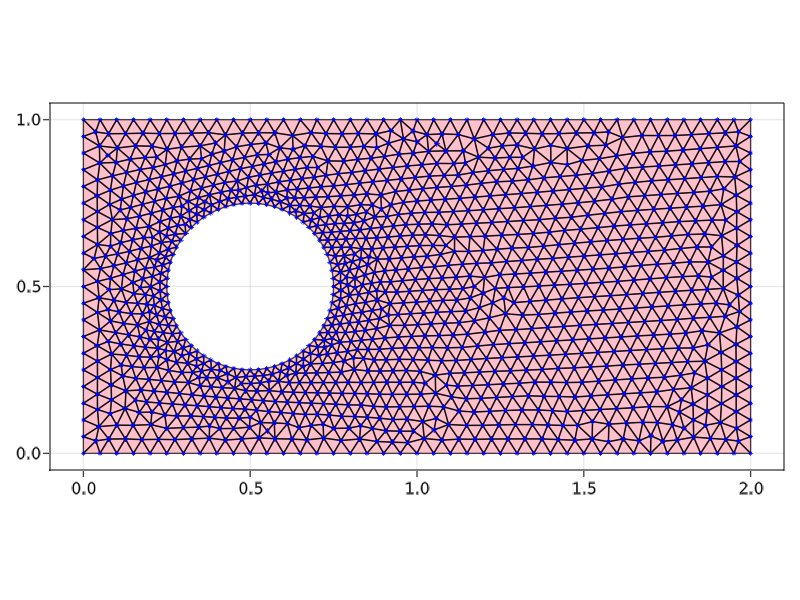

In [44]:
fig, ax = plot(Ω)
ax.aspect = AxisAspect(2)
wireframe!(Ω, color=:black, linewidth=1)
scatter!(Ω, marker=:star8, markersize=4, color=:blue)
fig

In [6]:
full_dirichlet = false
int_dirichlet = false
#full_dirichlet = true
int_dirichlet = true

true

Una vez que tenemos el grillado comenzamos a definir los elementos finitos que utilizaremos. En este caso usaremos elementos lagrangiano de **orden 1** que cumplirán una condición de Dirichlet en la región $\partial \Omega_{int}$. Al construirse la grilla esta región ha sido marcada como la frontera interior del rectángulo con el `tag` `"int"`. 

In [7]:
order = 2
reffe = ReferenceFE(lagrangian,Float64,order)
if int_dirichlet
    dirichlet_tags="int" 
elseif full_dirichlet
    dirichlet_tags=["int","ext"]
end
V = TestFESpace(model,reffe;conformity=:H1,dirichlet_tags = dirichlet_tags)

UnconstrainedFESpace()

En este ejemplo vamos a testear nuestro código utilizando una *solution*
que tomaremos como la función 

$$
u_e(x,y) =  4((x-x_0)^2 - (y-y_0)^3) - 5y
$$ 
Así 

$$
\Delta u_e = -f = 8 - 24(y-y0)
$$ 

y la condicines de contorno de Dirichlet / Neumann estarán dadas por 

$$
   u|_{\partial \Omega} = u_e|_{\partial \Omega} \;\;\;\;\;\; h = \hat{n} \cdot \nabla u_e|_{\partial \Omega}.
$$

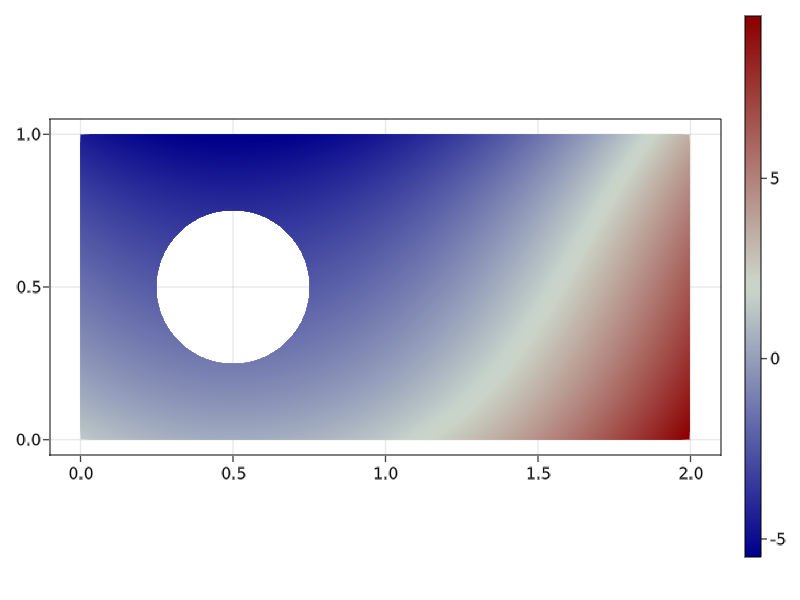

In [8]:
x0 = 0.5
y0 = 0.5
ue(x) = 4*((x[1]-x0)^2 - (x[2]-y0)^3) - 5.0*x[2] # "exact solution"

fig, ax, plt = plot(Ω, ue, shading=false)
ax.aspect = AxisAspect(2)
Colorbar(fig[1,2], plt)
fig


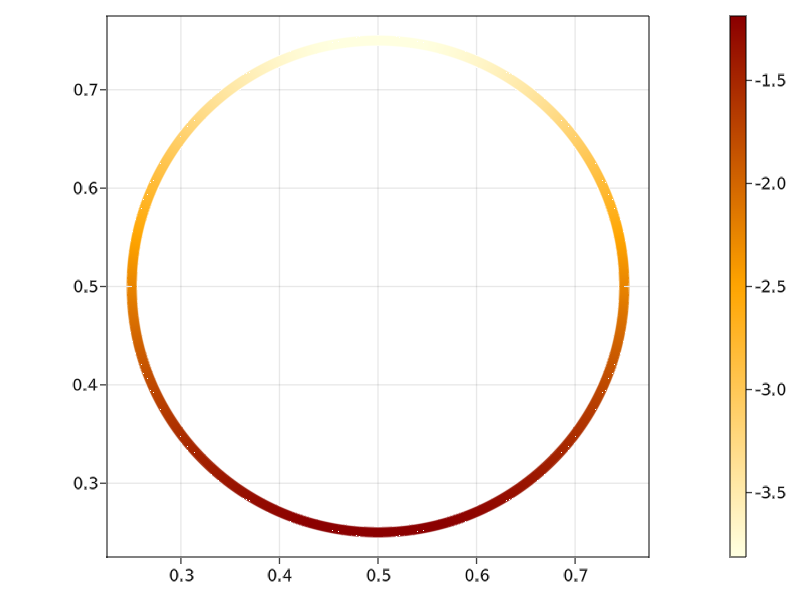

In [25]:
# internal Dirichlet boundary condition
U = TrialFESpace(V,ue)
Γ₁ = BoundaryTriangulation(model,tags=dirichlet_tags)
fig, ax , plt  = plot(Γ₁,ue, colormap=:heat, linewidth=10)
ax.aspect = AxisAspect(1)
Colorbar(fig[1,2], plt)
fig

In [26]:
if int_dirichlet
    neumann_tags = "ext"
    #neumanntags = "int"
    Γ = BoundaryTriangulation(model,tags=neumann_tags)
    dΓ = Measure(Γ,degree)
    nb = get_normal_vector(Γ)
end

GenericCellField():
 num_cells: 960
 DomainStyle: ReferenceDomain()
 Triangulation: BoundaryTriangulation()
 Triangulation id: 9734295368769819309

Para chequeo graficamos los valores de $\hat{n}\cdot \nabla u_e$ en el borde exterior.

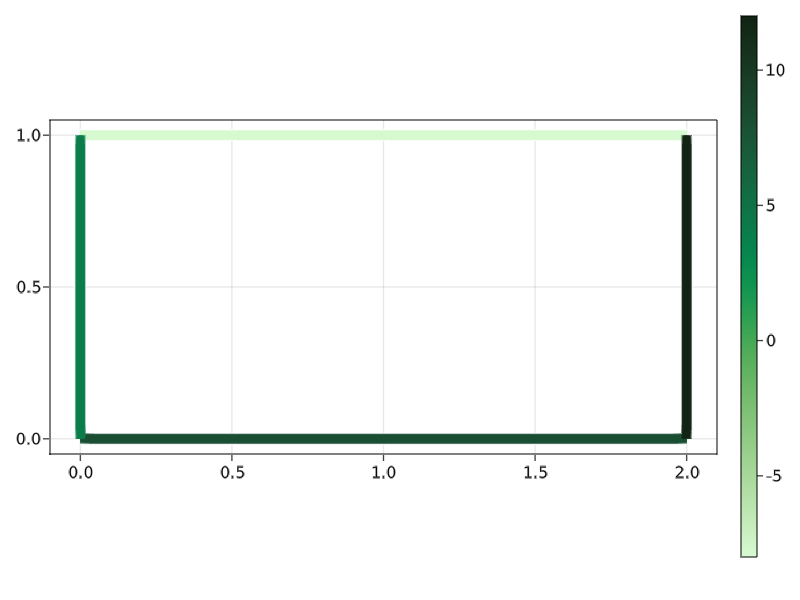

In [27]:
if int_dirichlet
    fig, ax , plt = plot(Γ, (nb ⋅ ∇(ue)), colormap=:algae, linewidth=10)
    ax.aspect = AxisAspect(2)
    Colorbar(fig[1,2], plt)
    fig
end

A continuación definimos el problema débil en forma abstracta:

In [28]:
f(x) = -8.0 + 24*(x[2] - y0) # source
#h(x) =  #external Neumann bc.
a(u,v) = ∫( ∇(v)⋅∇(u) )*dΩ  # en a(u,v) va toda la dependencia con u que es la incógnita. 
if full_dirichlet
    b(v) = ∫(v*f )*dΩ # aquí todo lo que es fuente. 
elseif int_dirichlet
    b(v) = ∫(v*f )*dΩ + ∫(v*(nb ⋅ ∇(ue)))*dΓ # aquí todo lo que es fuente. 
end

b (generic function with 1 method)

A partir de este punto el paquete **Gridap.jl** genera un sistema del tipo $Ax=b$ y lo resuelve para la versión elementos finitos de u.

In [29]:
op = AffineFEOperator(a,b,U,V)

AffineFEOperator()

In [30]:
ls = LUSolver()
solver = LinearFESolver(ls)

LinearFESolver()

In [31]:
uh = solve(solver,op)

SingleFieldFEFunction():
 num_cells: 157312
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 3462379202442735918

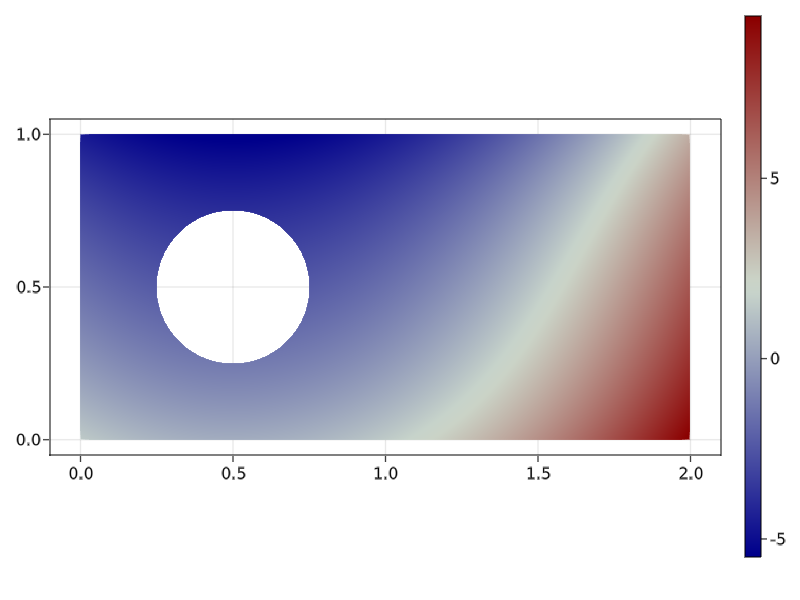

In [32]:
fig, ax, plt = plot(Ω, uh, shading=false)
ax.aspect = AxisAspect(2)
Colorbar(fig[1,2], plt)
fig

In [33]:
if full_dirichlet
    writevtk(Ω,"images/solución_dir",cellfields=["uh_dir" => uh])
elseif int_dirichlet
    writevtk(Ω,"images/solución_newmann",cellfields=["uh_neu" => uh])
end

(["images/solución_newmann.vtu"],)

Ahora vamos a validar la solución encontrada comparándola con la exacta, para ello introduciremos varias herramientas.

In [34]:
e = ue - uh

OperationCellField():
 num_cells: 157312
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 3462379202442735918

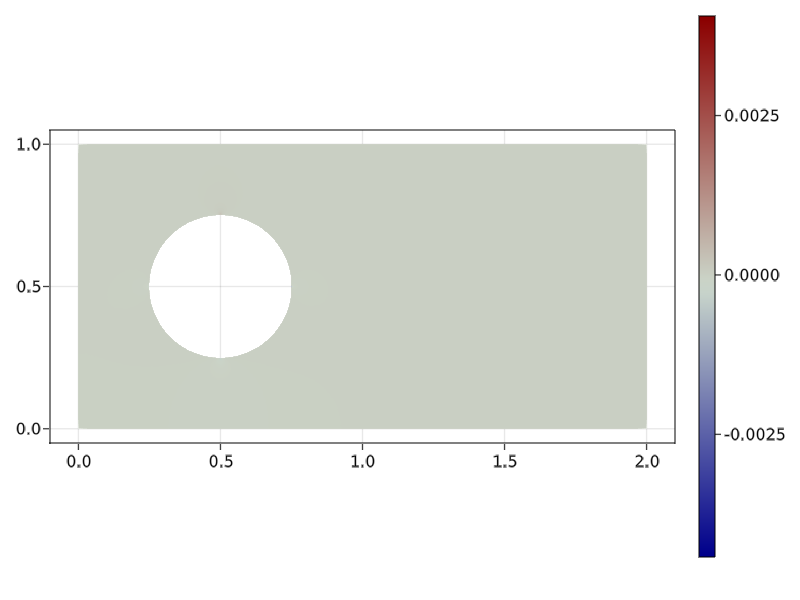

In [35]:
fig, ax, plt = plot(Ω, e
    , shading=false
    )
ax.aspect = AxisAspect(2)
Colorbar(fig[1,2], plt)
fig

In [36]:
if full_dirichlet
    writevtk(Ω,"images/error_dir",cellfields=["e_dir" => e])
elseif int_dirichlet
    writevtk(Ω,"images/error_newmann",cellfields=["e_neu" => e])
end

(["images/error_newmann.vtu"],)

A continuación calculamos la norma $L^2$ y $H^1$ del error. 

In [37]:
el2 = sqrt(sum( ∫( e*e )*dΩ ))
println("l2 error = ",el2)
eh1 = sqrt(sum( ∫( e*e + ∇(e)⋅∇(e) )*dΩ ))
println("h1 error = ",eh1)

l2 error = 9.407246301468106e-6
h1 error = 0.00748396060879008


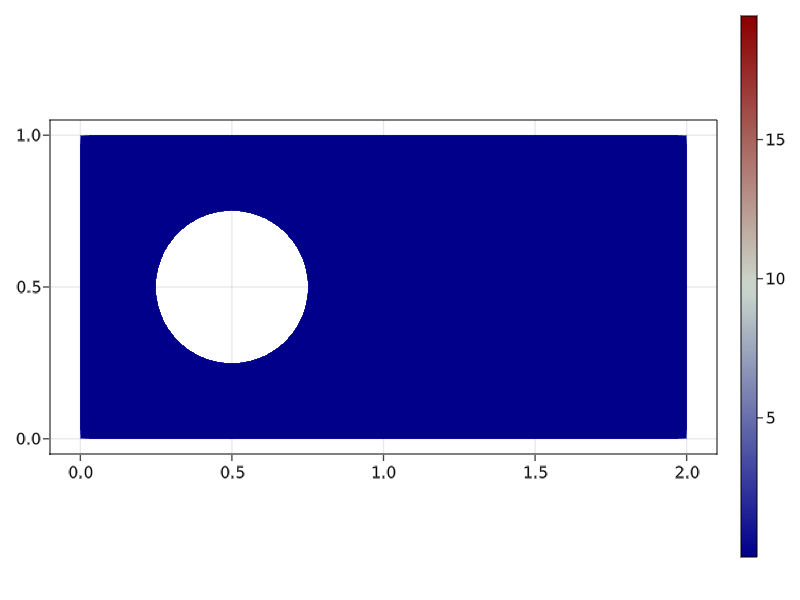

In [38]:
fig, ax, plt = plot(Ω, ∇(e)⋅∇(e), shading=false)
ax.aspect = AxisAspect(2)
Colorbar(fig[1,2], plt)
fig

Una vez obtenida la solución se pueden calcular algunas cantidades físicamente interesantes, por ejemplo la carga contenida en una región. Aquí calculamos la carga en la región exterior y en la interior. Note el cambio de signo para la interior ya que la normal siempre es toma saliente.

Recordemos que la carga se define como: 
\begin{equation}
Q_i = \int_{\partial \Omega_i} \sigma dS =  4\pi\int_{\partial \Omega_i} E \cdot \; dS
\end{equation}

Mientras que la  **matriz de capacidades** como: 

\begin{equation}
Q_i = C_{ij}V^j
\end{equation}

In [39]:
Q_ext = 1/4π*sum(∫((nb ⋅ ∇(uh)))*dΓ)

1.2732398912572593

In [40]:
dΓ₁ = Measure(Γ₁,degree)
    nb₁ = get_normal_vector(Γ₁)
Q_int = -1/4π*sum(∫((nb₁ ⋅ ∇(uh)))*dΓ₁)

0.12511988932177803